### Juan Blázquez Sánchez
Práctica 3 - FORECASTING & CLUSTERING - 29/11/2022


In [121]:
import requests
import math
import numpy as np
import pandas as pd
import requests
import math
import numpy as np
import pandas as pd
import seaborn as sns
import io
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima


## Preprocesado Forcasting

In [122]:
data = pd.read_excel('ataquesDoS.xls')
data

,Fecha,DoS
0,1960-01-01,3.360
1,1960-02-01,4.385
2,1960-03-01,4.055
3,1960-04-01,5.380
4,1960-05-01,6.309
...,...,...
475,1999-08-01,89.974
476,1999-09-01,97.462
477,1999-10-01,121.141
478,1999-11-01,124.069


In [123]:
# Using plotly.express
import plotly.express as px

fig = px.line(data, x='Fecha', y="DoS")
fig.show()

Como vemos hay tanto una componente estacionaria como una tendencia, vamos a dividirlas de forma multiplicativa ya que a mayor tendendecia se ve que la sesoanilidad es mas "grande".

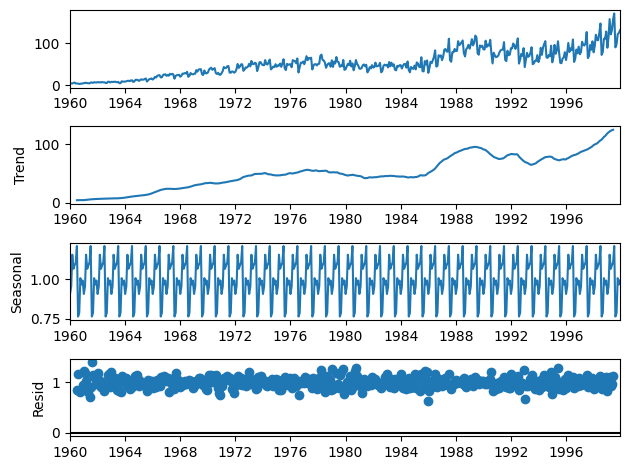

In [124]:
from statsmodels.tsa.seasonal import seasonal_decompose
data2=data.copy()

data2.set_index('Fecha', inplace=True)

analysis = data2[['DoS']].copy()


decompose_result_mult = seasonal_decompose(analysis, model="multiplicative")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

Vemos como la tendencia asciende segun los años, pero la componente seasonal es la misma, los valores residuales están en torno a 1.

## ARIMA

In [125]:
TEST_SIZE = 12  # Un años de Test
data.set_index('Fecha', inplace=True)
train, test = data.iloc[:-TEST_SIZE], data.iloc[-TEST_SIZE:]
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], data.shape[0]))
train.shape, x_train.shape, test.shape, x_test.shape

((468, 1), (468,), (12, 1), (12,))

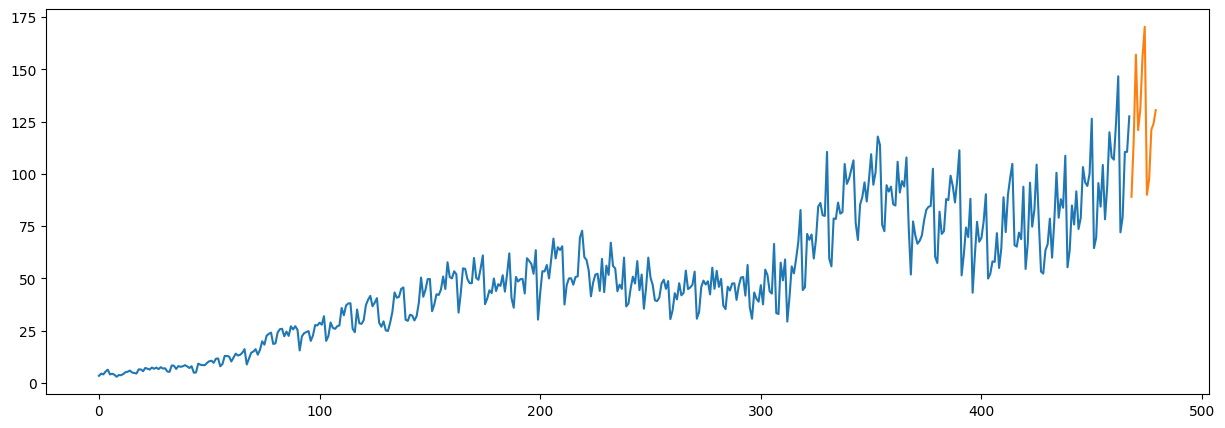

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)

In [127]:
model = auto_arima(train, start_p=0, start_q=0,
                      test='adf',
                      max_p=5, max_q=5,
                      m=12,             
                      d=1,          
                      seasonal=True,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3531.472, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3725.661, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3245.631, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3388.407, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3723.856, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3676.579, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3165.846, Time=0.33 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3461.651, Time=0.21 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3163.279, Time=1.06 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=3165.258, Time=1.68 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3163.323, Time=1.15 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=3270.632, Time=0.97 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=3098.801, Time=1.69 sec
 ARIMA(2,1,0)(1,0,1)[12]

In [128]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  468
Model:             SARIMAX(4, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1540.195
Date:                              Tue, 29 Nov 2022   AIC                           3094.390
Time:                                      19:05:13   BIC                           3123.414
Sample:                                  01-01-1960   HQIC                          3105.812
                                       - 12-01-1998                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6447      0.039    -16.673      0.000      -0.720      -0.569
ar.L2         -0.4358      0.051     -8.474      0.000      -0.537      -0.335
ar.L3         -0.0993      0.050     -1.999      0.046      -0.197      -0.002
ar.L4         -0.1042      0.045     -2.341      0.019      -0.191      -0.017
ar.S.L12       0.9822      0.010     95.692      0.000       0.962       1.002
ma.S.L12      -0.6375      0.039    -16.542      0.000      -0.713      -0.562
sigma2        40.7800      1.966     20.742      0.000      36.927      44.633
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               246.72
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):              10.86   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [129]:
# Forecast

prediction, confint = model.predict(n_periods=TEST_SIZE, return_conf_int=True)

prediction

1999-01-01    100.841151
1999-02-01    113.184258
1999-03-01    137.002902
1999-04-01    124.217426
1999-05-01    126.822392
1999-06-01    136.412446
1999-07-01    152.556841
1999-08-01     97.164239
1999-09-01    101.721152
1999-10-01    124.037449
1999-11-01    120.047275
1999-12-01    135.975580
Freq: MS, dtype: float64

In [130]:
prediction.index #Predicción de nuestro TEST

DatetimeIndex(['1999-01-01', '1999-02-01', '1999-03-01', '1999-04-01',
               '1999-05-01', '1999-06-01', '1999-07-01', '1999-08-01',
               '1999-09-01', '1999-10-01', '1999-11-01', '1999-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [131]:
cf= pd.DataFrame(confint) 


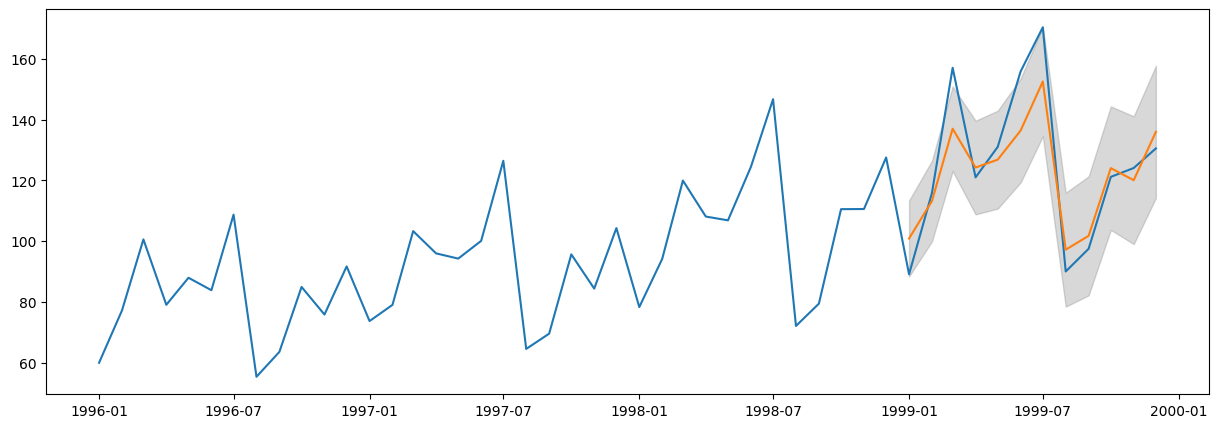

In [132]:
#Mostramos la gráfica con la predicción de los 2 últimos años en naranja
#sobre la serie real 
prediction_series = pd.Series(prediction,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(data["DoS"][-48:])
ax.plot(prediction_series[-48:])
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

Predicción de nuestro test graficado (1 año)

In [136]:
# Forecast

prediction, confint = model.predict(n_periods=TEST_SIZE+24, return_conf_int=True)
cf= pd.DataFrame(confint)[-25:]
prediction[-24:]

2000-01-01    113.093940
2000-02-01    124.654784
2000-03-01    147.452898
2000-04-01    135.271888
2000-05-01    137.555697
2000-06-01    147.106041
2000-07-01    163.023741
2000-08-01    108.507879
2000-09-01    113.042719
2000-10-01    134.951755
2000-11-01    131.018082
2000-12-01    146.682567
2001-01-01    124.196398
2001-02-01    135.553123
2001-03-01    157.949605
2001-04-01    145.981296
2001-05-01    148.226436
2001-06-01    157.606944
2001-07-01    173.240924
2001-08-01    119.694823
2001-09-01    124.148724
2001-10-01    145.668304
2001-11-01    141.804720
2001-12-01    157.190628
Freq: MS, dtype: float64

Valores predicción a dos años

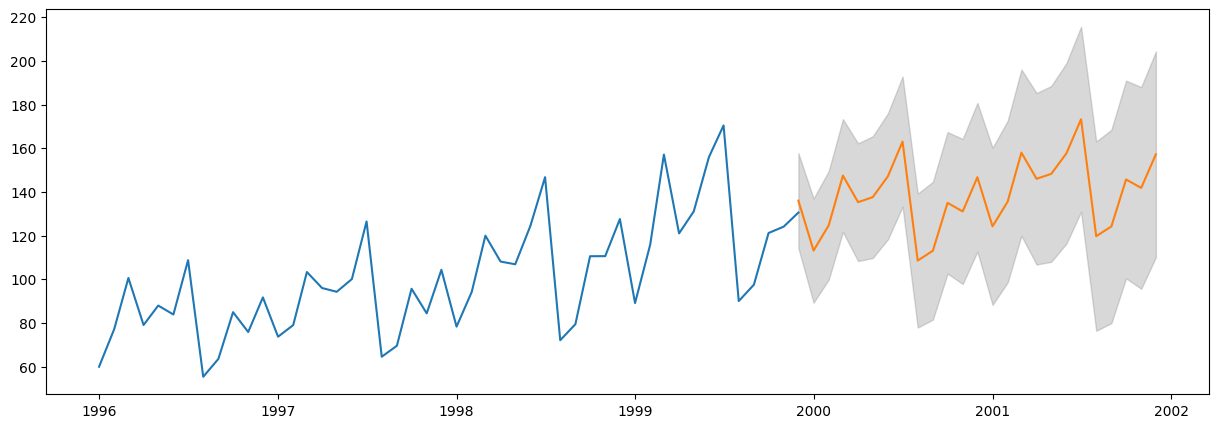

In [137]:
#Mostramos la gráfica con la predicción de los 2 últimos años en naranja
#sobre la serie real 
prediction_series = pd.Series(prediction,index=prediction.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(data["DoS"][-48:])
ax.plot(prediction_series[-25:])
ax.fill_between(prediction_series[-25:].index,
                cf[0],
                cf[1],color='grey',alpha=.3)

Valores de predicción a dos años graficado

## Preprocesado CLUSTERING

In [161]:
data = pd.read_excel('users.xlsx')
data

,Nombre,Departamento,App1,App2,App3,App4,App5,App6,App7,App8,...,App25,App26,App27,App28,App29,App30,App31,App32,App33,App34
0,Benjamin,7878,69,36,37,75,55,20,45,30,...,52,35,71,71,66,11,6,7,9,15
1,Isabella,8370,69,42,43,67,65,29,40,52,...,58,32,72,71,80,11,16,23,15,12
2,Martina,8370,76,77,73,56,72,68,83,80,...,76,71,39,43,36,12,17,23,12,10
3,Catalina,7878,73,54,42,54,75,26,56,57,...,74,52,58,76,63,10,9,19,10,16
4,Bautista,8603,72,44,76,81,60,77,61,54,...,58,74,31,30,20,6,16,16,15,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,Milagros Jazmin,9864,63,46,58,37,68,55,60,51,...,64,46,45,50,49,9,11,12,7,15
492,Ian Mateo,8302,56,50,25,53,50,22,48,32,...,39,42,55,60,57,7,7,8,8,12
493,Luz Martina,8305,59,51,28,48,42,22,41,27,...,38,39,59,68,61,10,11,11,9,11
494,Emma Francesca,8370,59,39,54,45,64,30,60,31,...,56,37,28,37,39,10,12,10,9,6


In [152]:
data.describe()

,Departamento,App1,App2,App3,App4,App5,App6,App7,App8,App9,...,App25,App26,App27,App28,App29,App30,App31,App32,App33,App34
count,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.00000,496.000000,496.000000,496.000000,...,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000
mean,8946.076613,71.189516,56.620968,50.826613,56.157258,64.538306,48.08871,60.594758,56.471774,50.818548,...,59.481855,53.985887,47.278226,51.802419,49.356855,15.262097,16.183468,19.070565,15.933468,16.294355
std,770.913244,5.357556,17.076935,18.536292,16.077447,14.252221,17.90503,18.004800,18.663723,16.654278,...,14.832931,14.231910,21.390435,21.847064,22.466399,17.722891,16.520835,15.685580,16.714525,17.959046
min,7878.000000,56.000000,14.000000,13.000000,14.000000,14.000000,0.00000,11.000000,0.000000,14.000000,...,0.000000,10.000000,10.000000,12.000000,0.000000,4.000000,5.000000,5.000000,5.000000,5.000000
25%,8315.000000,68.000000,46.000000,36.750000,49.000000,60.000000,34.00000,52.000000,45.750000,39.750000,...,52.000000,45.000000,24.000000,30.000000,26.000000,8.000000,9.000000,10.000000,9.000000,9.000000
50%,8581.000000,71.000000,60.000000,52.000000,57.500000,67.000000,50.00000,64.500000,60.000000,52.000000,...,61.000000,55.000000,50.000000,58.000000,54.000000,10.000000,12.000000,15.000000,11.000000,11.000000
75%,9864.000000,75.000000,70.000000,66.000000,67.000000,74.000000,60.00000,73.000000,71.000000,64.000000,...,70.000000,65.000000,67.000000,72.000000,70.000000,13.000000,14.000000,21.000000,14.000000,14.000000
max,10267.000000,92.000000,87.000000,92.000000,92.000000,94.000000,88.00000,96.000000,90.000000,85.000000,...,93.000000,84.000000,85.000000,88.000000,93.000000,86.000000,81.000000,82.000000,82.000000,87.000000


In [187]:
corr = data.corr ()
corr.style.background_gradient(cmap='coolwarm')

,Departamento,App1,App2,App3,App4,App5,App6,App7,App8,App9,App10,App11,App12,App13,App14,App15,App16,App17,App18,App19,App20,App21,App22,App23,App24,App25,App26,App27,App28,App29,App30,App31,App32,App33,App34
Departamento,1.000000,0.087042,-0.001577,0.016104,-0.009905,0.016233,0.028586,0.002528,0.048909,0.015853,0.018007,0.011359,0.055242,0.026977,0.105733,0.112787,0.042438,-0.003014,0.082322,-0.009044,-0.051203,0.015899,-0.026129,0.000829,-0.008759,0.017224,0.011605,0.017062,-0.000799,0.005135,0.025711,0.022965,0.015229,0.006966,0.026148
App1,0.087042,1.000000,0.305217,0.337875,0.279151,0.379752,0.403182,0.309414,0.376084,0.385946,0.439596,0.363130,0.221189,0.216414,0.344713,0.793984,0.230788,0.394600,0.264118,0.298759,0.259739,0.372042,0.276832,0.155963,0.336882,0.475552,0.403051,0.051295,0.064475,0.061773,-0.009609,0.012593,0.145977,0.019723,0.023733
App2,-0.001577,0.305217,1.000000,0.577957,0.329362,0.752912,0.613855,0.823148,0.823401,0.725905,0.669197,0.816449,0.703636,0.699308,0.614834,0.392500,0.590513,0.649270,-0.114035,0.596939,-0.183215,0.694917,0.294479,0.264586,0.735860,0.696162,0.630658,0.197939,0.233057,0.238539,-0.653913,-0.652468,-0.545885,-0.641121,-0.653462
App3,0.016104,0.337875,0.577957,1.000000,0.362203,0.613358,0.885546,0.842113,0.717937,0.716817,0.414103,0.768617,0.573396,0.534799,0.559572,0.412316,0.419075,0.754291,-0.167185,0.291125,-0.168931,0.870098,-0.025489,-0.256130,0.887512,0.716562,0.854549,-0.336863,-0.275974,-0.299667,-0.529853,-0.514830,-0.461818,-0.517644,-0.525618
App4,-0.009905,0.279151,0.329362,0.362203,1.000000,0.540582,0.397638,0.386156,0.320080,0.337076,0.351336,0.567245,0.178539,0.278126,-0.013762,0.300607,-0.041833,0.557434,0.232748,0.555420,0.495960,0.374666,0.612798,0.481755,0.414562,0.293128,0.447343,0.496142,0.501405,0.486670,-0.713465,-0.686343,-0.597371,-0.696752,-0.677611
App5,0.016233,0.379752,0.752912,0.613358,0.540582,1.000000,0.625681,0.786193,0.770078,0.770498,0.872799,0.898847,0.498769,0.466249,0.454132,0.435883,0.464863,0.713459,-0.102711,0.609447,-0.017811,0.740122,0.421419,0.427286,0.734913,0.834174,0.682401,0.339454,0.413811,0.377059,-0.781750,-0.774427,-0.670244,-0.765913,-0.776660
App6,0.028586,0.403182,0.613855,0.885546,0.397638,0.625681,1.000000,0.822846,0.769961,0.728050,0.449415,0.766450,0.566865,0.539203,0.598955,0.463590,0.460108,0.783714,-0.041494,0.374156,-0.075043,0.843738,0.077392,-0.137704,0.855793,0.718179,0.827421,-0.219045,-0.161722,-0.175787,-0.522808,-0.505389,-0.424519,-0.508220,-0.515955
App7,0.002528,0.309414,0.823148,0.842113,0.386156,0.786193,0.822846,1.000000,0.849804,0.788083,0.606288,0.924288,0.758656,0.714647,0.696624,0.397075,0.601572,0.772000,-0.144803,0.494489,-0.247849,0.860085,0.127610,0.000462,0.898553,0.789232,0.795514,-0.076118,-0.015591,-0.026047,-0.705731,-0.701964,-0.631148,-0.693321,-0.704282
App8,0.048909,0.376084,0.823401,0.717937,0.320080,0.770078,0.769961,0.849804,1.000000,0.858530,0.685157,0.844942,0.638475,0.603103,0.664623,0.452518,0.588826,0.744496,-0.111128,0.514133,-0.179732,0.826492,0.201643,0.118607,0.803500,0.792414,0.741974,0.029491,0.087300,0.075519,-0.611452,-0.601526,-0.501977,-0.595970,-0.611968
App9,0.015853,0.385946,0.725905,0.716817,0.337076,0.770498,0.728050,0.788083,0.858530,1.000000,0.698145,0.793400,0.505232,0.463496,0.531377,0.414307,0.471273,0.731488,-0.178587,0.447316,-0.139233,0.834575,0.191425,0.131988,0.767263,0.788018,0.778163,0.028927,0.100038,0.067357,-0.585335,-0.565661,-0.463458,-0.565503,-0.584143


In [153]:
data.isnull().sum().sum() 

0

No hay nulos

In [154]:
len(list(data["Departamento"]))

496

Esta variable no tiene información, la eliminamos

In [166]:
columns_names = data.columns.values
columns_names = np.delete(columns_names, [0,1]) 
columns_names

array(['App1', 'App2', 'App3', 'App4', 'App5', 'App6', 'App7', 'App8',
       'App9', 'App10', 'App11', 'App12', 'App13', 'App14', 'App15',
       'App16', 'App17', 'App18', 'App19', 'App20', 'App21', 'App22',
       'App23', 'App24', 'App25', 'App26', 'App27', 'App28', 'App29',
       'App30', 'App31', 'App32', 'App33', 'App34'], dtype=object)

In [158]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering,KMeans

In [167]:
scaler=StandardScaler()
scaled_array=scaler.fit_transform(data[columns_names])

In [168]:
df_sc=pd.DataFrame(scaled_array,columns=columns_names)
df_scaled=df_sc.copy()

## Clustering Jerarquico

In [174]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(Z=linkage_matrix, **kwargs)

In [176]:
corte_altura=40
num_clusters=None
jerarquico=AgglomerativeClustering(compute_full_tree=True,distance_threshold=corte_altura,n_clusters=num_clusters,linkage='ward',compute_distances=True)
df_scaled['cluster']=jerarquico.fit_predict(df_sc)

In [177]:
df_scaled['cluster'].value_counts()

0    209
2    166
1     79
3     42
Name: cluster, dtype: int64

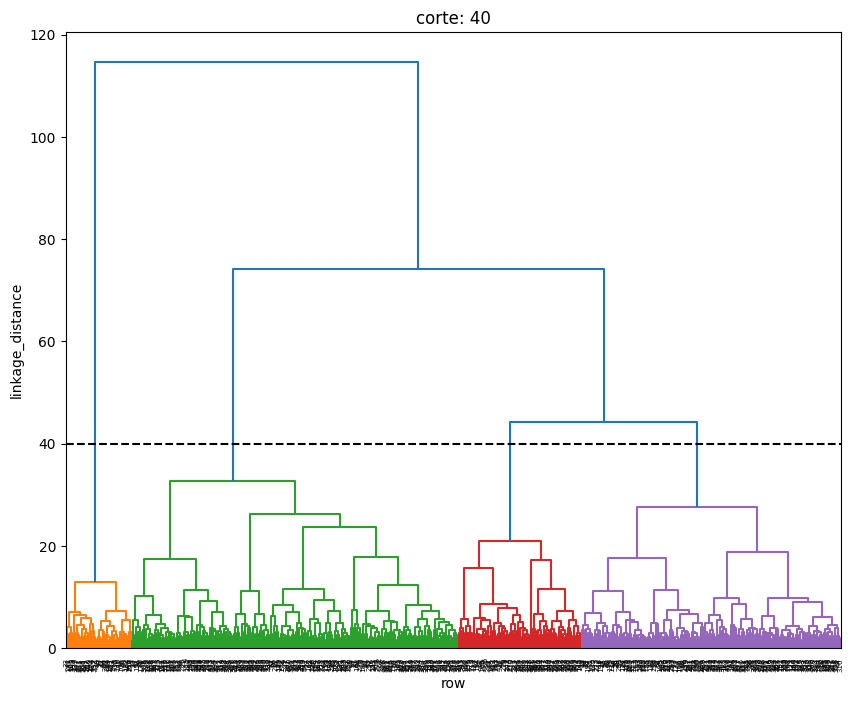

In [178]:
fig,ax=plt.subplots(figsize=(10,8))

plot_dendrogram(jerarquico,ax=ax,color_threshold=corte_altura)

ax.axhline(y=corte_altura,c='black',linestyle='--',label='altura del corte')
ax.set_title('dendograma')
ax.set_xlabel('row')
ax.set_ylabel('linkage_distance');
#ax.set_ylim(0,20);
ax.set_title('corte: {}'.format(corte_altura));

En este caso elegimos 40 como altura y marcamos 4 grupos diferentes, podriamos bajar la distancia de corte, con un PCA vamos a ver como se dividen estos grupos

In [179]:
from sklearn.decomposition import PCA

In [180]:
pca_object=PCA(n_components=2)
df_pca=pca_object.fit_transform(df_scaled.drop('cluster',axis=1))
df_pca=pd.DataFrame(df_pca,columns=['PC1','PC2'],index=df_scaled.index)
df_pca['cluster']=df_scaled['cluster']

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

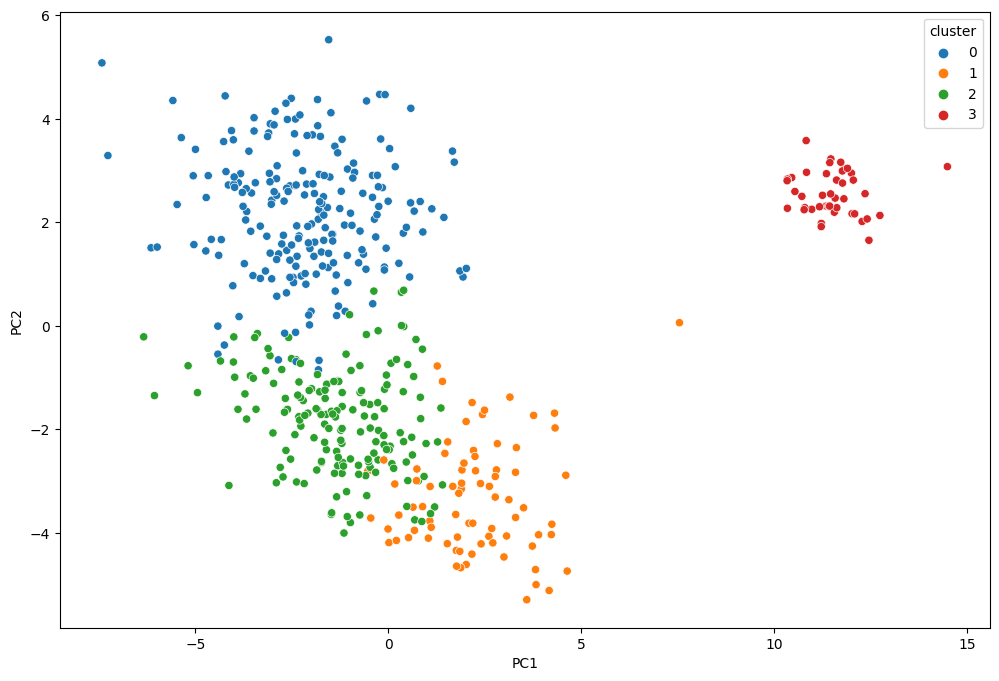

In [181]:
fig,ax=plt.subplots(figsize=(12,8))

sns.scatterplot(data=df_pca,x='PC1',y='PC2',hue='cluster',ax=ax,palette='tab10')

<AxesSubplot:xlabel='App1', ylabel='App31'>

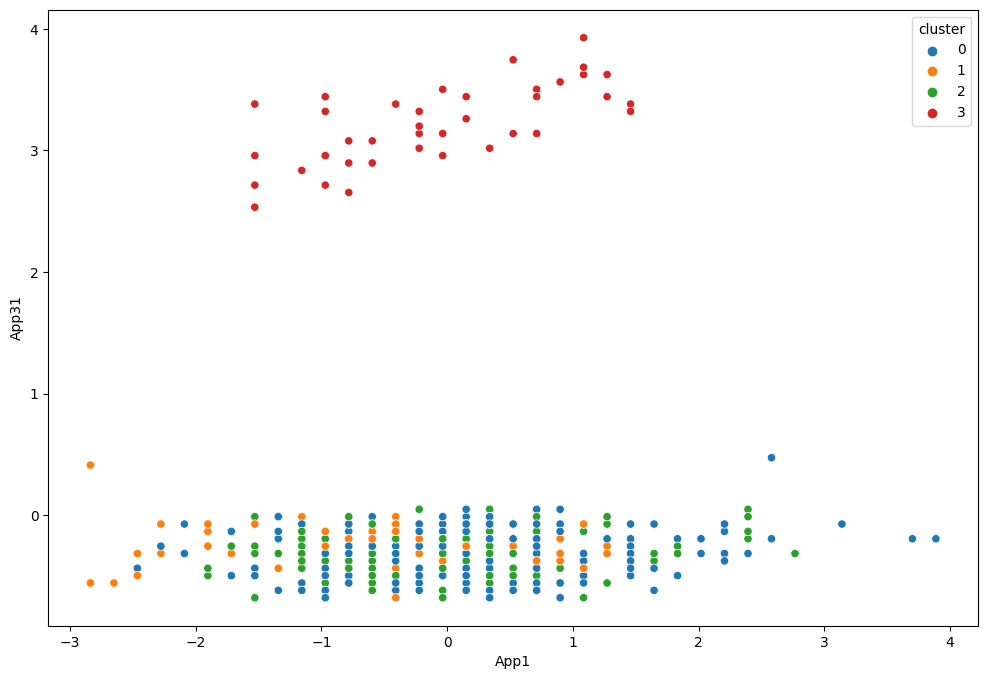

In [188]:
fig,ax=plt.subplots(figsize=(12,8))

sns.scatterplot(data=df_scaled,x='App1',y='App31',hue='cluster',ax=ax,palette='tab10')

<AxesSubplot:xlabel='App2', ylabel='App3'>

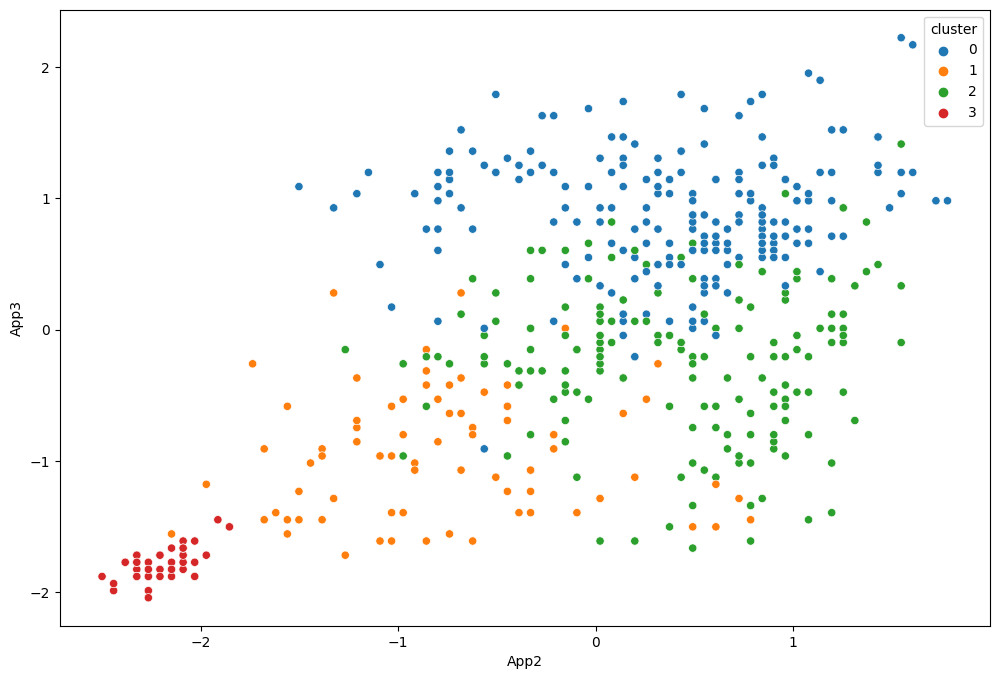

In [192]:
fig,ax=plt.subplots(figsize=(12,8))

sns.scatterplot(data=df_scaled,x='App2',y='App3',hue='cluster',ax=ax,palette='tab10')

## KMeans

In [195]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples,silhouette_score

In [202]:
elbow_vector=[]
slh_vector=[]
for cluster in range(2,10):
  kmeans=KMeans(n_clusters=cluster,init='k-means++',n_init=20)
  clusters_labels=kmeans.fit_predict(df_scaled)
  elbow_vector.append(kmeans.inertia_)
  slh_avg=silhouette_score(df_scaled,clusters_labels)
  slh_vector.append(slh_avg)

Text(0, 0.5, 'Inertia')

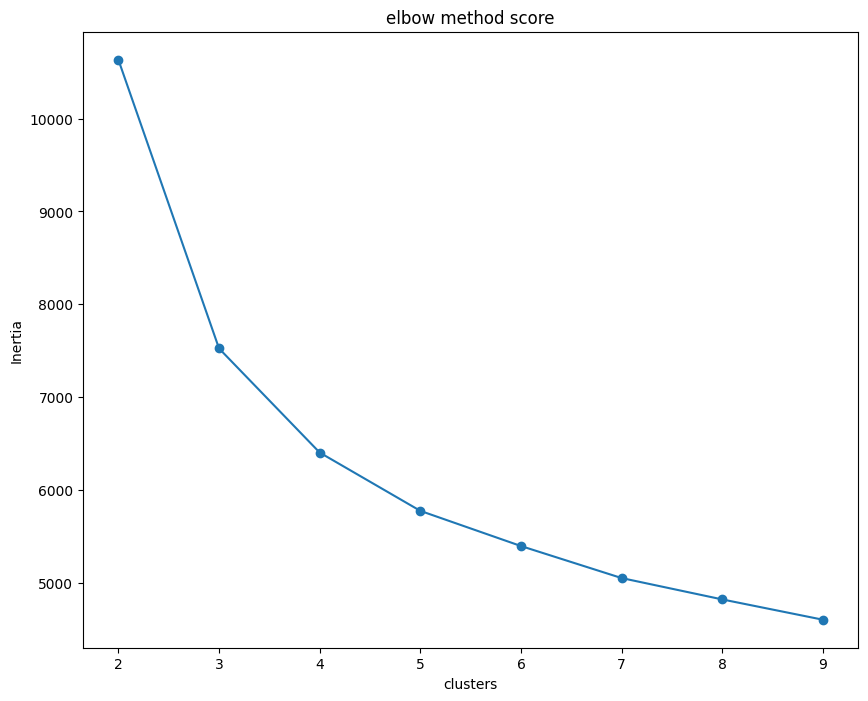

In [204]:
fig,ax=plt.subplots(figsize=(10,8))
ax.plot(range(2,10),elbow_vector,marker='o')
#plt.plot()
ax.set_title('elbow method score')
ax.set_xlabel('clusters')
ax.set_ylabel('Inertia')

Text(0, 0.5, 'silhouette score avg')

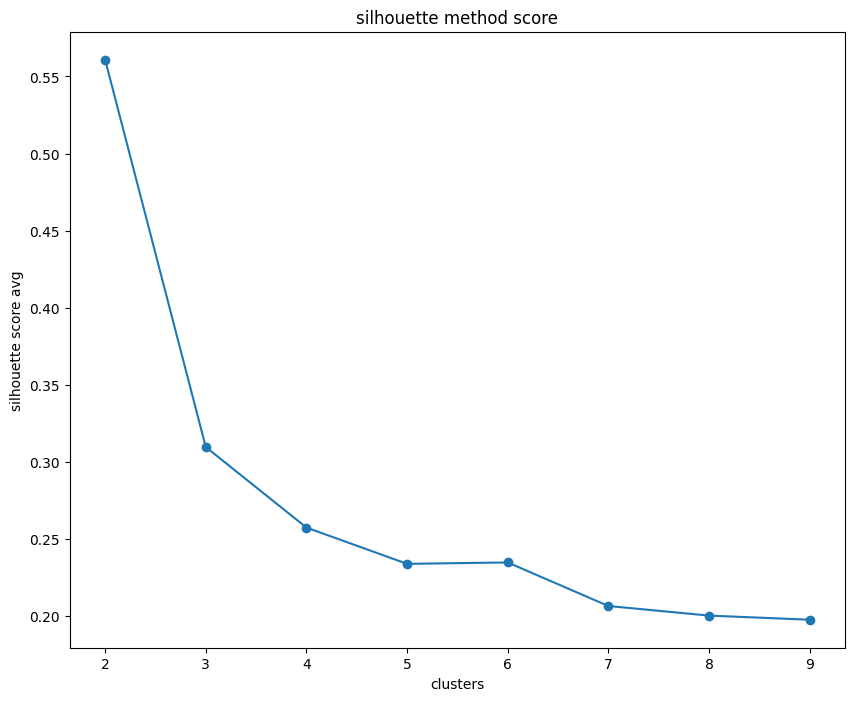

In [206]:
fig,ax=plt.subplots(figsize=(10,8))
ax.plot(range(2,10),slh_vector,marker='o')
ax.set_title('silhouette method score')
ax.set_xlabel('clusters')
ax.set_ylabel('silhouette score avg')

Pese a que dos clusters tengan el mejor silhouette score, si ns fijamos en el elbow y entendiendo la grafica del PCA del Jerarquico mvemos como la mejor división es de 3 o 4 clusters, en este caso escogeremos 3 clusters ya tienen un mayor silhouette score.

In [207]:
kmeans=KMeans(n_clusters=3,init='random',n_init=20)
clusters_labels=kmeans.fit_predict(df_scaled)
data['cluster']=clusters_labels

In [208]:
data.groupby(['cluster']).mean()

,Departamento,App1,App2,App3,App4,App5,App6,App7,App8,App9,...,App25,App26,App27,App28,App29,App30,App31,App32,App33,App34
cluster,,,,,,,,,,,,,,,,,,,,,
0,8955.027273,72.540909,64.213636,67.254545,56.790909,70.181818,62.231818,73.972727,68.327273,61.163636,...,68.554545,64.463636,33.100000,38.318182,35.063636,10.000000,11.345455,14.640909,11.131818,10.654545
1,9005.255814,70.395349,19.441860,18.790698,19.093023,27.488372,16.581395,18.720930,17.883721,18.465116,...,31.953488,27.279070,17.767442,18.372093,16.186047,71.209302,68.255814,65.813953,68.511628,72.860465
2,8926.703863,70.060086,56.313305,41.227468,62.399142,66.047210,40.549356,55.690987,52.399142,47.021459,...,55.995708,49.021459,66.111588,70.703863,68.974249,9.905579,11.141631,14.626609,10.763948,11.180258


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

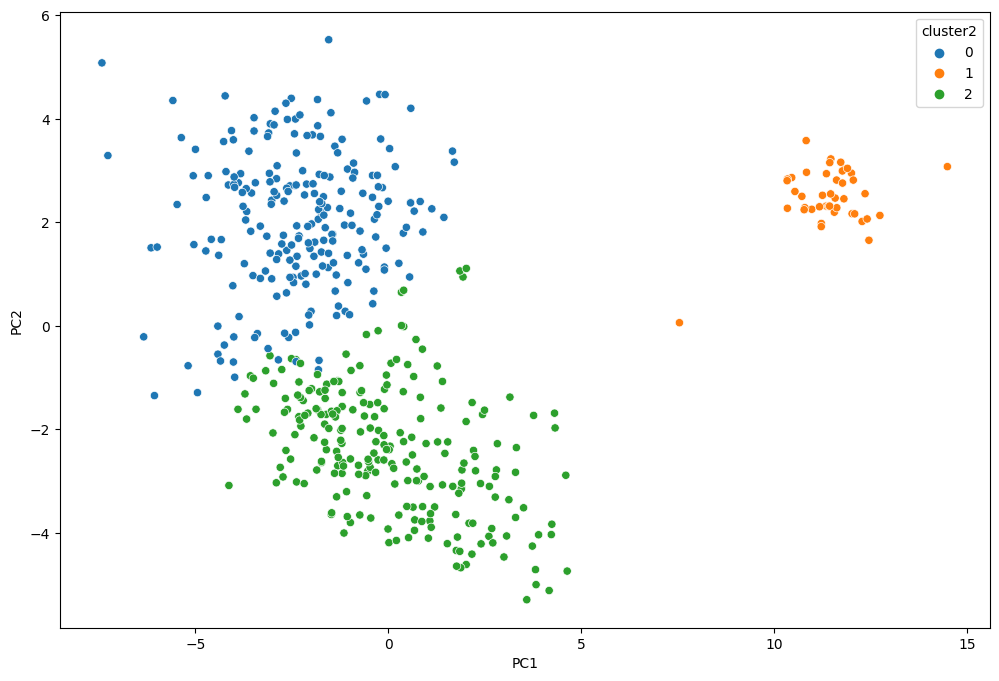

In [211]:
fig,ax=plt.subplots(figsize=(12,8))
df_pca['cluster2']=data['cluster']
sns.scatterplot(data=df_pca,x='PC1',y='PC2',hue='cluster2',ax=ax,palette='tab10')

<AxesSubplot:xlabel='App1', ylabel='App31'>

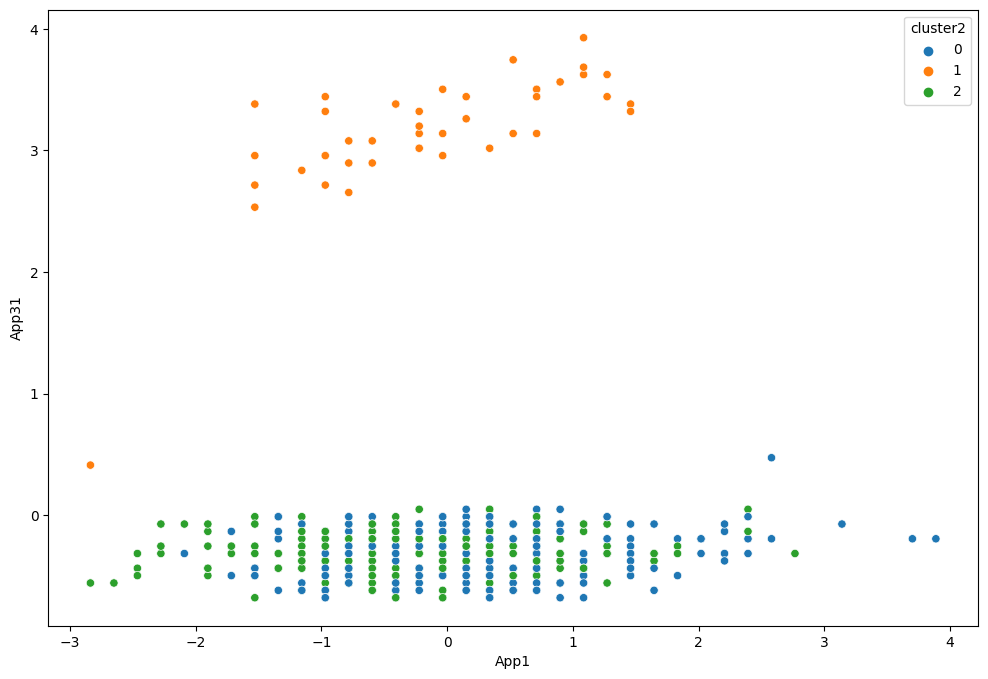

In [213]:
fig,ax=plt.subplots(figsize=(12,8))
df_scaled['cluster2']=data['cluster']
sns.scatterplot(data=df_scaled,x='App1',y='App31',hue='cluster2',ax=ax,palette='tab10')

<AxesSubplot:xlabel='App2', ylabel='App3'>

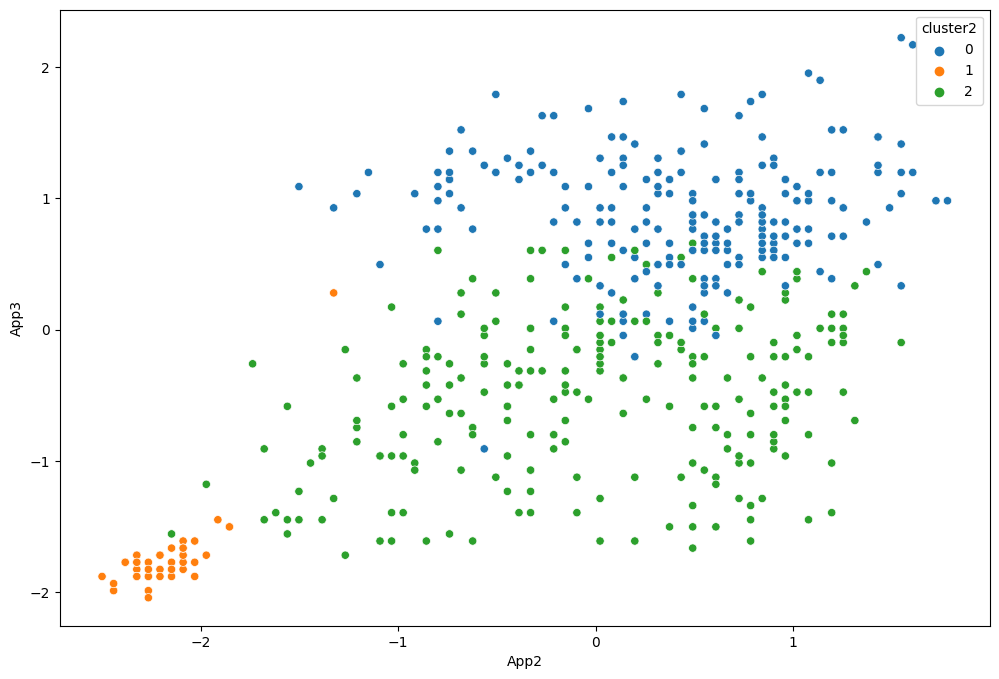

In [214]:
fig,ax=plt.subplots(figsize=(12,8))
df_scaled['cluster2']=data['cluster']
sns.scatterplot(data=df_scaled,x='App2',y='App3',hue='cluster2',ax=ax,palette='tab10')